# TPU를 사용하기 위한 설정

In [ ]:
!nvidia-smi 

Wed Aug  4 09:43:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 기본 구성

In [ ]:
# !pip install transformers
!pip install transformers==3.2

In [ ]:
pip install tensorflow-addons

### Colab에서 Mecab 설치

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from tensorflow.keras.models import clone_model

from tqdm import tqdm

# from keras import optimizers
from transformers import *
# from transformers import BertTokenizer, TFBertModel,PreTrainedTokenizerFast, TFBartModel
# from kobart_transformers import get_kobart_tokenizer, get_kobart_model

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences #tensorflow 전처리 모듈1
from tensorflow.keras.preprocessing.text import Tokenizer #tensorflow 전처리 모듈2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 그래프를 출력창에서 바로 볼 수 있게함
%matplotlib inline 


# BERT를 이용한 NEWS Topic 분류

### **Tokenizer code**




In [ ]:
import logging
import os
import unicodedata
from shutil import copyfile
 
from transformers import PreTrainedTokenizer
 
 
logger = logging.getLogger(__name__)
 
VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}
 
PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}
 
PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}
 
PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}
 
SPIECE_UNDERLINE = u'▁'
 
 
class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES
 
    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )
 
        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)
 
        self.max_len_single_sentence = self.max_len - 2  # take into account special tokens
        self.max_len_sentences_pair = self.max_len - 3  # take into account special tokens
 
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
 
        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt
 
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)
 
    @property
    def vocab_size(self):
        return len(self.idx2token)
 
    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state
 
    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)
 
    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')
 
        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()
 
        return outputs
 
    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)
 
        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)
 
        return new_pieces
 
    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])
 
    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]
 
    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string
 
    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A RoBERTa sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep
 
    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """
 
        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))
 
        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]
 
    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A BERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]
 
    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return
 
        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])
 
        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)
 
        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1
 
        return out_vocab_model, out_vocab_txt

In [ ]:
PATH = '/content/drive/MyDrive/gh/dacon_newstopic'
train      = pd.read_csv(PATH + '/DATA/train_clean_4bert.csv')
test       = pd.read_csv(PATH + '/DATA/test_clean_4bert.csv')
submission = pd.read_csv(PATH + '/DATA/sample_submission.csv')
topic_dict = pd.read_csv(PATH + '/DATA/topic_dict.csv')

In [ ]:
train

,Unnamed: 0,index,title,topic_idx,ko_to_en,en_to_ko,c_title,c_title_enko
0,0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,travelers' anger during the flight cancellatio...,인천 핀란드 항공편 취소 당시 여행자들의 분노,인천 핀란드 항공기 결항 휴가철 여행객 분통,인천 핀란드 항공편 취소 당시 여행자들의 분노
1,1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,I'll cross Silicon Valley. 15 trillion won in ...,나는 실리콘밸리를 건너갈 것이다 구글이 미국을 세계화하는 데 15조원이 투입됐다.,실리콘밸리 넘어서겠다 구글 number조원 들여 미국전역 거점화,나는 실리콘밸리를 건너갈 것이다 구글이 미국을 세계화하는 데 number조원이 투입됐다
2,2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,the solution to easing Iran's foreign tension ...,이란의 외국 긴장을 완화하기 위한 해법은 미국 경제전쟁을 중단하는 것이다.,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,이란의 외국 긴장을 완화하기 위한 해법은 미국 경제전쟁을 중단하는 것이다
3,3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,a combination of special relations with Korean...,NYT 클린턴과 가까운 한국 기업과의 특별한 관계가 결합된 것,nyt 클린턴 측근한국기업 특수관계 조명 공과 사 맞물려종합,nyt 클린턴과 가까운 한국 기업과의 특별한 관계가 결합된 것
4,4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,the hope for a quick settlement of the U.S.-Ch...,"시진핑 트럼프 국가주석과의 미,중 무역협상이 빠르게 타결될 수 있기를 희망한다.",시진핑 트럼프에 중미 무역협상 조속 타결 희망,시진핑 트럼프 국가주석과의 미 중 무역협상이 빠르게 타결될 수 있기를 희망한다
...,...,...,...,...,...,...,...,...
45649,45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,a partnership with KB Financial's U.S. IB Steel,KB금융의 미국 IB스틸과의 제휴,kb금융 미국 ib 스티펠과 제휴 선진국 시장 공략,kb금융의 미국 ib스틸과의 제휴
45650,45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,a review of postponement and closure of the op...,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사,number보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토,서울시교육청에서 새로운 코로나 개장 연기 및 폐쇄 심사
45651,45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,an actual investment tournament for Kiwoom Sec...,게시판에서 열린 2020년 키움증권 실제 투자대회,게시판 키움증권 number 키움 영웅전 실전투자대회,게시판에서 열린 number년 키움증권 실제 투자대회
45652,45652,45652,답변하는 배기동 국립중앙박물관장,2,"Bae Ki-dong, head of the National Museum of Korea",배기동 국립중앙박물관장,답변하는 배기동 국립중앙박물관장,배기동 국립중앙박물관장


In [ ]:
train_length = train['c_title'].astype(str).apply(len)
train_length.max()

70

Text(0, 0.5, 'counts')

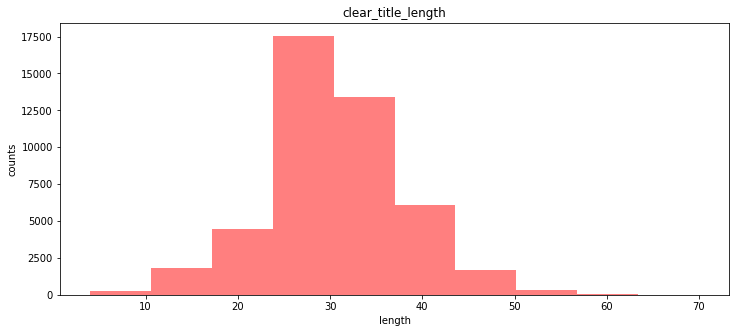

In [ ]:
plt.figure(figsize=(12,5)) # (가로, 세로) 형태의 tuple로 입력
plt.hist(train_length, alpha=0.5, color='r',label='word') # alpha 그래프 색상 투명도, label: 그래프 label
# plt.yscale('log', nonposy='clip')
plt.title("clear_title_length") #그래프 제목
plt.xlabel("length") # x축 label
plt.ylabel("counts") # x축 label

In [ ]:
# MAX_LEN 설정시 확인
print('문장 길이 최댓값 : {}'.format(np.max(train_length))) # title길이 최대값
print('문장 길이 최소값 : {}'.format(np.min(train_length))) # title길이 최소값
print('문장 길이 평균값 : {:.2f}'.format(np.mean(train_length))) # title길이 평균값
print('문장 길이 표준편차 : {:.2f}'.format(np.std(train_length))) # title길이 표준편차
print('문장 길이 중간값 : {}'.format(np.median(train_length))) # title길이 중간값
# 사분위의 경우 0~100 스케일 되어있음
print('문장 길이 제1사분위 : {}'.format(np.percentile(train_length, 25))) # title길이 1사분위
print('문장 길이 제3사분위 : {}'.format(np.percentile(train_length, 75))) # title길이 3사분위

문장 길이 최댓값 : 70
문장 길이 최소값 : 4
문장 길이 평균값 : 30.37
문장 길이 표준편차 : 7.42
문장 길이 중간값 : 30.0
문장 길이 제1사분위 : 26.0
문장 길이 제3사분위 : 34.0


In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1321: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,
Setting 'max_len_single_sentence' is now deprecated. This value is automatically set up.
Setting 'max_len_sentences_pair' is now deprecated. This value is automatically set up.


In [ ]:
model_name = 'monologg/kobert'
SEED_NUM = 977
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)
BATCH_SIZE = 128
NUM_EPOCHS = 30
VALID_SPLIT = 0.2
MAX_LEN = 36
NUM_CLASS = 7
K_SPLIT = 3
# 이상치 데이터로인해 평균이 급격히 올라갈수 있기에 EDA분석을 통해 적절히 정해야함 평균값이던 중간값이던 3사분위 값이던
# EDA를 통해 이상치 데이터가 없으면 최대값이용

In [ ]:
# BERT에 필요한 입력값은 총 3개
# input_ids : 문장을 tokenize해서 index로 변환
# attention_mask : 1은 attention에 영향을 받음, 0은 영향을 받지 않음
# token_type_ids : 0과 1로 문장의 토큰 값을 분리

# special token 역할
# [UNK] : 모르는 단어에 대한 token
# [MASK] : 마스크 token, 사전학습(Pre-training)에서 활용
# [PAD] : 최대 길이를 맞추는 용도
# [SEP] : 문장의 종결을 알림
# [CLS] : 문장의 시작을 알림

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        
        text = sent,
        add_special_tokens = True, # True : 토큰 시작점에 [CLS] 토큰과 토큰의 마지막에 [SEP]토큰을 붙임
        max_length = MAX_LEN, # MAX_LEN 최대 길이에 따라 문장의 길이를 맞추는 작업을 진행 ; MAX_LEN보다 길면 truncate
        pad_to_max_length = True, # True : MAX_LEN의 길이에 미치지 못하는 문장에 padding을 적용 **padding : 길이를 일괄적으로 맞춰주는 것
                                                     # 각 데이터의 길이가 다를경우 모델에 적용할 수 없음 그렇기에 padding진행
                                         
        return_attention_mask = True, # True : BERT에 필요한 입력값 중 attention_mask를 생성
        truncation = True 
        # encoded_plus 과정 중 token_type으로 문장이 1개면 0, 문장이 2개면 0과 1로 구분
    )


    input_id = encoded_dict['input_ids'] # BERT 입력값 중 하나인 input_ids
    attention_mask = encoded_dict['attention_mask'] # attention_mask ; 단순히 padding과 non-padding을 구분
    token_type_id = encoded_dict['token_type_ids'] # 두개의 문장 구분용


    return input_id, attention_mask, token_type_id # 각각의 BERT 입력값들을 encoded_dict를 한 결과를 return

In [ ]:
print(tokenizer.all_special_tokens) # BERT special tokens
print(tokenizer.all_special_ids)  # BERT special tokens의 index

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[0, 3, 1, 2, 4]


In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for train_sent, train_label in tqdm(zip(train["c_title"], train["topic_idx"])): 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)
        
    except Exception as e:
        print(e)
        print(train_sent)
        pass


train_news_input_ids = np.array(input_ids, dtype=int)
train_news_attention_masks = np.array(attention_masks, dtype=int)
train_news_type_ids = np.array(token_type_ids, dtype=int)

# 최종 출력값은 numpy로 변환한 후 tuple 형태로 묶어서 저장
train_news_inputs = (train_news_input_ids, train_news_attention_masks, train_news_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) # 정답 tokenizing 리스트


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
45654it [00:07, 6452.25it/s]


In [ ]:
# bert_tokenizer를 통해 실제결과가 나오는지 테스트
INPUT_id = train_news_input_ids[30]
ATTENTION_mask = train_news_attention_masks[30]
TOKEN_TYPE_id = train_news_type_ids[30]

print(INPUT_id)
print(ATTENTION_mask)
print(TOKEN_TYPE_id)
print(tokenizer.decode(INPUT_id))

[   2  517 6605 7096 7565 2643 6150  517  367  398  382 5163 4841 6853
 2268 4519 7979 1133 7438 7328 7053 6694 1542    3    1    1    1    1
    1    1    1    1    1    1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 셰이크 살만 afc 회장 평양 방문 최휘 국가체육지도위원장스포츠 뉴스[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]


In [ ]:
class TFBertClassifier(tf.keras.Model): # pre_trained된 bert model을 불러와 그 위에 완전연결층 1층을 쌓은 구조
                                                              # class로 모델을 구현하려면 tf.keras.Model을 상속받아야 함
    # TFBertClassifier생성할 때마다 __init__실행                                                          
    def __init__(self, model_name, dir_path, num_class): # model_name : 인자로 받아 활용할 모델 이름, dir_path : 모델이 저장된 위치
                                                                                            # num_class : 원하는 정답의 개수(감성분석인 경우 2; 긍정, 부정)
        # super함수를 통해 부모 클래스(tf.keras.Model)에 있는 __init__함수 호출   
        # tf.keras.Model 클래스를 상속받는 경우 super함수를 통해 부모 클래스에 __init__ 함수의 인자에 모델이름을 전달하면
        # tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름으로 공통적으로 사용
        super(TFBertClassifier, self).__init__()

         
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True) # 기존에 pre_trained 한 부분이 로드됨
                                                                                                                                    
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob) # 과적합을 방지하기 위한 layer
        # self.classifier을 통해 topic_idx를 전부 분류
        self.classifier = tf.keras.layers.Dense(num_class,
                                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                                    name="classifier")  # 완전연결층 1층


    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False): 
        #__init__에서 선언한 내용을 실제 입력을 받고 실행하는 call 메서드임
        # call함수를 호출하면 입력한 inputs을 통해 마지막에 예측값을 출력
        # 영화 리뷰 text를 inputs을 통해 받음
        

        # output 값 : sequence_output, pooled_output, (hidden_states), (attentions)
        # sequence_output : sequence 길이의 출력을 모두 입력으로 받음; 이 벡터의 차원 ' 임베딩 크기 * 최대문장길이'
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids) # bert를 통해 outputs로 결과값을 추출
        pooled_output = outputs[1] # pooled_output
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output) # self.classifier를 통해 완전연결층을 활용하여 최종적으로 self.num_labels 개수에 맞는 예측값을 출력

        return logits

cls_model = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


### Adam최적화와 손실값, 모델 정확도 정의

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
# optimizer = tf.keras.optimizers.Nadam(learning_rate=10e-5, decay=1e-5)
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=5.0e-5, total_steps = 2344*4, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer,
                                loss=loss,
                                metrics=[metric])

In [ ]:
# 모델이 어느 시점이 되면 학습평가점수는 높아지는데 검증평가 점수가 낮아지는 overfitting현상이 발생하거나
# 학습도중 특정 상태의 모델에서 하이퍼파라미터를 바꿔서 다시 학습을 진행할 수도 있음
# => tensowflow.keras.callback 모듈의 EarlyStopping, ModelCheckpoint 클래스를 활용하여 해결


# 특정 epoch에서 현재 검증 평가 점수가 이전 검증 평가 점수보다 일정수치 미만으로 낮아지면 학습을 멈추는 역할
# 학습 중 overfitting을 방지한다는 것
es_callback = EarlyStopping(
                                monitor='val_loss', # 'val_accuracy'를 통해 검증 평가 점수로 활용한다는 것
                                mode='min',
                                min_delta=0.0001, # 활용한 평가 점수에 따라 현재 점수가 이전 점수에 비해 0.0001 보다 낮아지면 overfitting현상이 발생한다고 생각하고 학습을 멈춤
                                patience=10,
                                baseline=0.4
                                 ) # 검증 평가 점수가 이전 최고 점수보다 높아지지 않는 epoch수가 patience에 입력한 횟수를 넘어가면 학습을 멈춤

# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)


#PATH = '/content/drive/MyDrive/gh/dacon_newstopic'
DATA_OUT_PATH = '/content/drive/MyDrive/gh/dacon_newstopic/Ensemble_ml'
# 오류시 DATA_OUT_PATH = '/content/gdrive/MyDrive/bert_data_out'

checkpoint_path = DATA_OUT_PATH +  '/best_modeling.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

# Epoch마다 모델을 저장하게끔 함(학습중 모델을 저장한다는 것)    
cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', # save_best_only를 하는 평가기준
    verbose=1, 
    save_best_only=True, # True : 가장 성능이 좋은 모델만 저장한다는 것
    save_weights_only=True # True : 모델 그래프를 전부 저장하는 것이 아닌 모델 가중치만 저장한다는 것
    )


/content/drive/MyDrive/gh/dacon_newstopic/Ensemble_ml -- Folder already exists 



In [ ]:
history = cls_model.fit(train_news_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        batch_size=BATCH_SIZE,
                        validation_split = VALID_SPLIT, 
                        callbacks=[es_callback, cp_callback]
                        )

Epoch 1/30
286/286 [==============================] - 215s 570ms/step - loss: 1.6382 - accuracy: 0.3899 - val_loss: 0.8791 - val_accuracy: 0.7517

Epoch 00001: val_loss improved from inf to 0.87913, saving model to /content/drive/MyDrive/gh/dacon_newstopic/Ensemble_ml/best_modeling.ckpt
Epoch 2/30
286/286 [==============================] - 161s 562ms/step - loss: 0.4427 - accuracy: 0.8674 - val_loss: 0.4286 - val_accuracy: 0.8582

Epoch 00002: val_loss improved from 0.87913 to 0.42858, saving model to /content/drive/MyDrive/gh/dacon_newstopic/Ensemble_ml/best_modeling.ckpt
Epoch 3/30
286/286 [==============================] - 161s 562ms/step - loss: 0.3351 - accuracy: 0.8905 - val_loss: 0.3945 - val_accuracy: 0.8673

Epoch 00003: val_loss improved from 0.42858 to 0.39450, saving model to /content/drive/MyDrive/gh/dacon_newstopic/Ensemble_ml/best_modeling.ckpt
Epoch 4/30
286/286 [==============================] - 161s 562ms/step - loss: 0.2861 - accuracy: 0.9040 - val_loss: 0.4110 - val

In [ ]:
cls_model.summary()

Model: "tf_bert_classifier_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model_9 (TFBertModel multiple                  92186880  
_________________________________________________________________
dropout_379 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  5383      
Total params: 92,192,263
Trainable params: 92,192,263
Non-trainable params: 0
_________________________________________________________________


## 모델 Test

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# bert_tokenizer를 이용하여 encoding진행
for test_sent in test["c_title"]: 
    try:

        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        
    except Exception as e:
        print(e)
        print(test_sent)
        pass


test_news_input_ids = np.array(input_ids, dtype=int)
test_news_attention_masks = np.array(attention_masks, dtype=int)
test_news_type_ids = np.array(token_type_ids, dtype=int)

test_news_inputs = (test_news_input_ids, test_news_attention_masks, test_news_type_ids)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# model.load_weights(checkpoint_filepath)
cls_model_1 = TFBertClassifier(model_name=model_name,
                                                dir_path='bert_ckpt', # ???
                                                num_class=NUM_CLASS) # num_class 바꿔야함
cls_model_1.load_weights(os.path.join(DATA_OUT_PATH,'best_modeling.ckpt')) # 오류시 '/weight.h5'



All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
predictions = cls_model_1.predict(test_news_inputs)

In [ ]:
predictions

array([[ 3.955875  ,  0.2972363 ,  2.1797886 , ..., -1.5193585 ,
        -3.616293  , -3.192545  ],
       [-1.4345429 , -2.1512873 ,  1.1650326 , ..., -1.5962516 ,
        -2.1318808 , -0.9330474 ],
       [-0.05924818,  0.41515836,  4.806476  , ..., -2.8760314 ,
        -3.2577872 ,  1.0033107 ],
       ...,
       [-0.78842425, -2.149912  ,  4.544483  , ..., -1.964364  ,
        -3.0918355 , -1.996188  ],
       [ 2.212691  , -1.6819382 ,  3.762167  , ..., -1.3268167 ,
        -2.7382402 , -2.2514353 ],
       [ 0.6039132 ,  0.52606815,  4.1784525 , ..., -2.5242257 ,
        -3.406886  ,  2.539793  ]], dtype=float32)

In [ ]:
pred = np.argmax(predictions, axis = 1)
submission.topic_idx = pred
submission.sample(3)

#submission.to_csv(path, index = False)

,index,topic_idx
6885,52539,4
7356,53010,1
656,46310,0


In [ ]:
submission

,index,topic_idx
0,45654,0
1,45655,3
2,45656,2
3,45657,2
4,45658,3
...,...,...
9126,54780,3
9127,54781,2
9128,54782,2
9129,54783,2


In [ ]:
submission.to_csv(PATH + '/Ensemble_ml/tokenizing4bert_maxlen_34_5_.csv',index = False)
# submission.to_csv('bert_baseline_1.csv',index = True)

In [ ]:
print(history.history)

{'loss': [1.638214349746704, 0.44265809655189514, 0.33507493138313293, 0.28613799810409546, 0.23014487326145172, 0.18551412224769592, 0.1426164209842682, 0.11346527934074402, 0.08818844705820084, 0.06951534748077393, 0.05637185275554657, 0.04268477112054825, 0.03793001547455788, 0.032126009464263916, 0.02822291851043701], 'accuracy': [0.3899186849594116, 0.8674259781837463, 0.8905073404312134, 0.9039782881736755, 0.9202146530151367, 0.9359855651855469, 0.9515373706817627, 0.961887001991272, 0.9698820114135742, 0.97612464427948, 0.981244683265686, 0.9854612350463867, 0.9871587753295898, 0.9890753626823425, 0.9905264973640442], 'val_loss': [0.8791336417198181, 0.42858046293258667, 0.3945043385028839, 0.41103824973106384, 0.3911018669605255, 0.41475313901901245, 0.47344210743904114, 0.5138406157493591, 0.5839837193489075, 0.6229504346847534, 0.6112972497940063, 0.6919891238212585, 0.6862285733222961, 0.7513283491134644, 0.7679136991500854], 'val_accuracy': [0.751724898815155, 0.8581754565

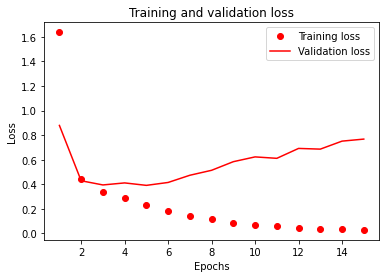

In [ ]:


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

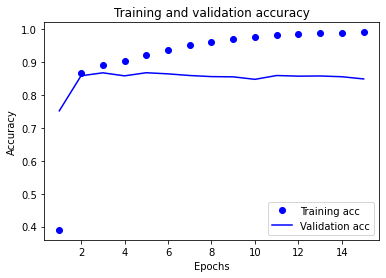

In [ ]:
plt.clf()   # 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()